In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.seasonal import STL
from statsmodels.tsa.stattools import adfuller

In [11]:
df = pd.read_csv('Data/dataset-case-iqvia.csv', sep=',')

In [14]:
def prep_df(dsupp_id, region_nm):

    df_copy = df[(df['dsupp_id'] == dsupp_id) &(df['region_nm'] == region_nm)].copy()
    
    df_copy = df_copy.groupby(['week_dt', 'dsupp_id', 'region_nm'])['units_qty'].sum().reset_index()
    
    df_copy['week_dt'] = pd.to_datetime(df_copy['week_dt'])
    
    df_copy = df_copy.sort_values('week_dt')
    
    df_copy.set_index('week_dt', inplace=True)

    return df_copy

df = prep_df(1, 'Sul')

In [15]:
df

,dsupp_id,region_nm,units_qty
week_dt,,,
2022-11-01,1,Sul,604.0
2022-11-06,1,Sul,4854.0
2022-11-13,1,Sul,854.0
2022-11-20,1,Sul,1083.0
2022-11-27,1,Sul,520.0
...,...,...,...
2024-10-01,1,Sul,2937.0
2024-10-06,1,Sul,3305.0
2024-10-13,1,Sul,558.0


---

# EDA

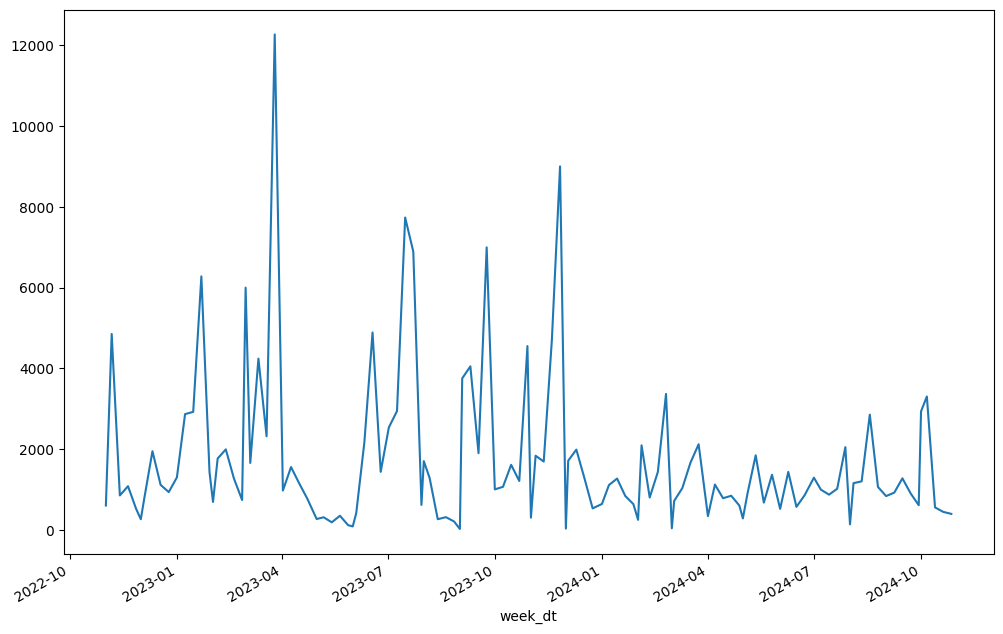

In [16]:
plt.figure(figsize=(12,8))
df['units_qty'].plot()
plt.show()

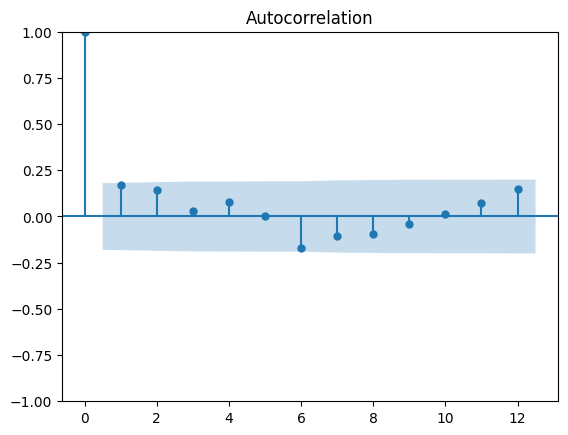

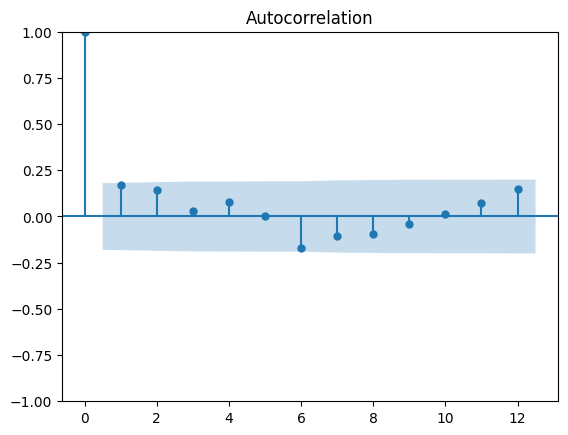

In [17]:
plot_acf(df['units_qty'], lags=12)

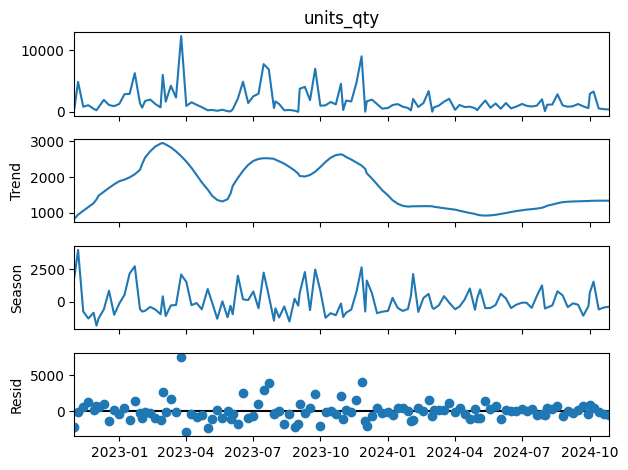

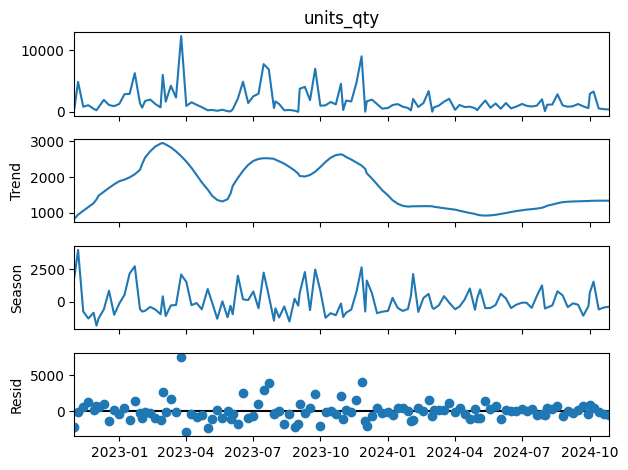

In [18]:
stl = STL(df['units_qty'], period=12)
res = stl.fit()
res.plot()

---

# SARIMAX - Região e Distribuidor

In [38]:
df = pd.read_csv('Data/dataset-case-iqvia.csv', sep=',')

In [35]:
def sarimax_group(dsupp_id, region_nm):

    # Pré-processamento
    
    df_filtered = df[ (df['dsupp_id'] == dsupp_id) & (df['region_nm'] == region_nm) ].copy()

    df_filtered = df_filtered.groupby(['week_dt', 'dsupp_id', 'region_nm'])['units_qty'].sum().reset_index()

    df_filtered['week_dt'] = pd.to_datetime(df_filtered['week_dt'])
    
    df_filtered = df_filtered.sort_values('week_dt')

    df_filtered.set_index('week_dt', inplace=True)

    # Feature Engineering

    for lag in [1, 2, 3, 4, 5, 6, 12]:
        df_filtered[f'lag_{lag}'] = df_filtered['units_qty'].shift(lag)
        
    df_filtered['rolling_mean_3'] = df_filtered['units_qty'].shift(1).rolling(window=3).mean()
    df_filtered['rolling_mean_6'] = df_filtered['units_qty'].shift(1).rolling(window=6).mean()
    df_filtered['rolling_std_3'] = df_filtered['units_qty'].shift(1).rolling(window=3).std()
    df_filtered['rolling_std_6'] = df_filtered['units_qty'].shift(1).rolling(window=6).std()

    df_filtered['month'] = df_filtered.index.month
    df_filtered['year'] = df_filtered.index.year
    df_filtered['week'] = df_filtered.index.isocalendar().week.astype(int)

    df_filtered.dropna(inplace=True)

    # print(df_filtered.head())

    # Modelo SARIMAX

    y = df_filtered['units_qty']
    
    exog = df_filtered[[
        'lag_1', 'lag_2', 'lag_3', 'lag_4', 'lag_5', 'lag_6', 'lag_12',
        'rolling_mean_3', 'rolling_mean_6', 'rolling_std_3', 'rolling_std_6'
    ]]
    
    model = SARIMAX(
        y,
        exog=exog,
        order=(1, 1, 1),
        seasonal_order=(1, 1, 1, 13), 
        enforce_stationarity=False,
        enforce_invertibility=False
    )

    # Treinamento

    pred = model.fit(disp=False)

    df_filtered['forecast'] = pred.predict(start=0, end=len(df_filtered)-1, exog=exog)

    # Comparação

    plt.figure(figsize=(14, 5))
    plt.plot(df_filtered.index, df_filtered['units_qty'], label='Demanda Real', color='black')
    plt.plot(df_filtered.index, df_filtered['forecast'], label='Previsão SARIMAX', color='red', linestyle='--')
    plt.title(f'Demanda Real vs. Prevista - Distribuidor {dsupp_id} | Região {region_nm}')
    plt.xlabel('Data')
    plt.ylabel('Unidades')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    return pred

H:\Users\Henry\anaconda3\envs\huggingface\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
H:\Users\Henry\anaconda3\envs\huggingface\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
H:\Users\Henry\anaconda3\envs\huggingface\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


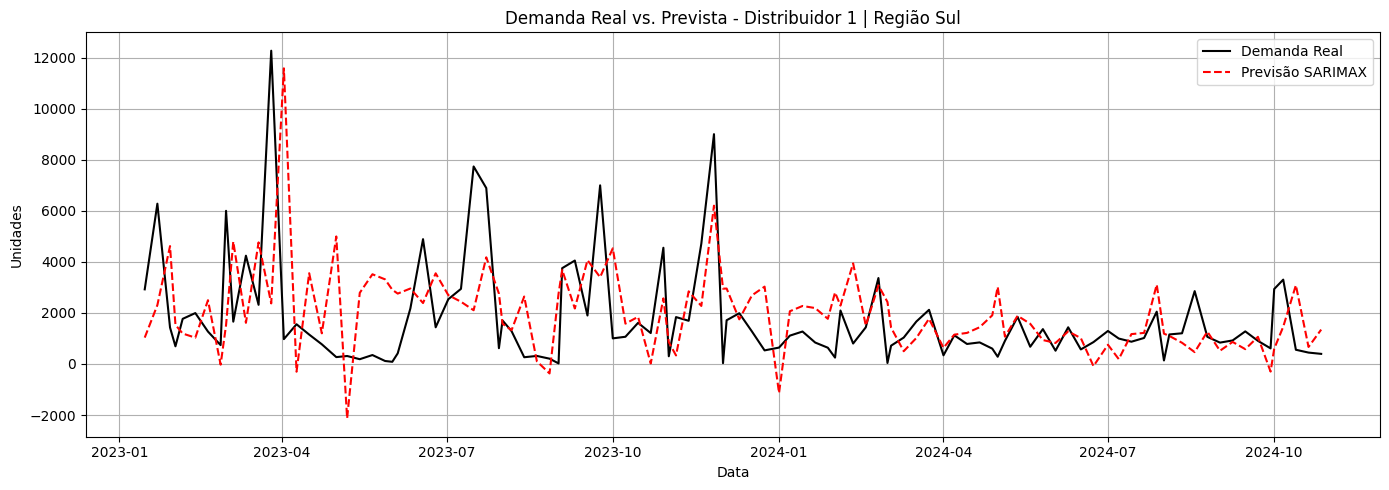

In [36]:
model = sarimax_group(1, 'Sul')